In [2]:
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.keys import Keys
import os
from selenium.webdriver.common.action_chains import ActionChains
import time
import re
import getpass
import json
from graph_tool.all import *

def login(username=None,password=None):
    if username == None:
        username = raw_input('username: ')
    if password == None:
        password = getpass.getpass()
    chromeDriver = '/Users/Jai/Downloads/chromedriver'
    chrome_options = webdriver.ChromeOptions()
    prefs = {"profile.managed_default_content_settings.notifications": 2}
    chrome_options.add_experimental_option("prefs", prefs)

    os.environ["webdriver.chrome.driver"] = chromeDriver
    driver = webdriver.Chrome(chromeDriver, chrome_options=chrome_options)

    driver.get("https://web.facebook.com/")
    assert 'Facebook' in driver.title
    email_field = driver.find_element_by_id("email")
    pass_field = driver.find_element_by_id("pass")

    email_field.send_keys(username)
    pass_field.send_keys(password)
    pass_field.send_keys(Keys.RETURN)
    return driver

def getLikesFromPosts(target, driver):
    # open the persons profile
    pageURL = str()
    if re.match(r'https?\:\/\/www\.facebook\.com\/[^?]*\?',target):
        pageURL = target
    else:
        pageURL = "https://web.facebook.com/" + target
    driver.get(pageURL)
    # TODO: replace with code that ensures we are at the bottom of the page
    for i in range(2):
        for i in range(2):
            ActionChains(driver).key_down(Keys.DOWN).perform()
        time.sleep(0.1)
    try:
        coverPhotoObj = driver.find_element_by_xpath('//*[@id="fbCoverImageContainer"]')
        coverPhotoObj.click()
    except NoSuchElementException:
        print "Cover photo not found"
    time.sleep(5)
    friends = set()
    reactionPageURLs = set()
    CoverObjectReactionElements = set()
    allCoverLinks = driver.find_elements_by_tag_name('a')
    for x in allCoverLinks:
        if '/ufi/reaction/profile/browser/' in str(x.get_attribute('href')):
            CoverObjectReactionElements.add(x.get_attribute('href'))
    reactionPageURLs = reactionPageURLs.union(CoverObjectReactionElements)
    try:
        closeButtonObj = driver.find_element_by_xpath('//*[@id="photos_snowlift"]/div[2]/div/a')
        closeButtonObj.click()
    except NoSuchElementException:
        print "DP not found"
    time.sleep(1)
    DPObj = driver.find_element_by_class_name('profilePic')
    DPObj.click()
    time.sleep(5)
    DPReactionElements = set()
    allDPLinks = driver.find_elements_by_tag_name('a')
    for x in allDPLinks:
        if '/ufi/reaction/profile/browser/' in str(x.get_attribute('href')):
            DPReactionElements.add(x.get_attribute('href'))
    reactionPageURLs = reactionPageURLs.union(DPReactionElements)

    # print "links found:"
    # for URL in reactionPageURLs:
    #     print URL
    for element in reactionPageURLs:
        link = element
        print "exploring " + str(link)
        friendsFoundFromLink = getLikesFromReactionPage(link, driver)
        friends = friends.union(friendsFoundFromLink)
    return friends


def getLikesFromReactionPage(likelistURL, driver):
    driver.get(likelistURL)
    more = True
    while more:
        try:
            time.sleep(5)
            seemorebutton = driver.find_element_by_xpath('//*[@id="reaction_profile_pager1"]/div')
            seemorebutton.click()
        except NoSuchElementException:
            more = False
    friendlinks = driver.find_elements_by_xpath(
        '//*[@id="reaction_profile_browser1"]/li/div/div/div/div[2]/div[2]/div/a')
    result = set()
    for linkelement in friendlinks:
        # result.add(linkelement.get_attribute("href"))
        link = linkelement.get_attribute("href")
        name = linkelement.text
        idsearch = re.search(r'(https?\:\/\/(www\.)?(web\.)?facebook\.com\/)([^?]*)\?',link)
        if idsearch:
            #print "adding " + idsearch.group(4)
            result.add((idsearch.group(4),name))
    return result

def hasFriendListVisible(target, driver):
    driver.get("https://web.facebook.com/" + target + '/friends')
    time.sleep(2)
    types_visible = driver.find_elements_by_class_name('_3sz')
    for friendType in types_visible:
        if friendType.text == 'All Friends':
            return True
    return False

def getFriendListFromFriendsPage(target, driver):
    driver.get("https://web.facebook.com/" + target + '/friends')
    lastHeight = driver.execute_script("return document.body.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)
        newHeight = driver.execute_script("return document.body.scrollHeight")
        if newHeight == lastHeight:
            break
        lastHeight = newHeight
    friendsOfTarget = driver.find_elements_by_class_name('fwb')
    #print friendsOfTarget[:50]

    friends = list()
    friends_names = list()
    for element in friendsOfTarget:
        try:
            friend_link = element.find_element_by_tag_name('a')
            if friend_link and friend_link.get_attribute('href') and re.match(
                r'(https?\:\/\/(www\.)?(web\.)?facebook\.com\/)([^?]*)\?', friend_link.get_attribute('href')):
                friends.append(friend_link.get_attribute('href'))
                friends_names.append(friend_link.text)
                #print friend_link.get_attribute('href')
        except NoSuchElementException:
            continue
    result = set()
    zipped = zip(friends,friends_names)
    for (link,name) in zipped:
        idsearch = re.search(r'(https?\:\/\/(www\.)?(web\.)?facebook\.com\/)([^?]*)\?',link)
        if idsearch:
            newelement= (idsearch.group(4),name)
            result.add(newelement)
            #print newelement
    return result

def getFriendList(target,driver):
    if target =='profile.php':
        return set()
    if hasFriendListVisible(target,driver):
        return getFriendListFromFriendsPage(target,driver)
    else:
        return getLikesFromPosts(target,driver)

def genFriendGraph(target, friendList):
    '''
    To generate the graph for a given root node and his/her friend list
    :param root: the root node as (fb-id , name)
    :param friendList: a list of tuples of (link,name)
    :return: the graph object
    '''
    g = Graph()
    root = g.add_vertex()
    g.gp.idtovert = g.new_gp("python::object")
    g.gp.idtovert = dict()
    g.gp.idtovert[target[0]]=0
    g.vp.vertexText = g.new_vp("string")
    g.vp.vertexText[root] = target[1]
    g.vp.id = g.new_vp("string")
    for friend in friendList:
        friendVertex = g.add_vertex()
        g.gp.idtovert[friend[0]] = g.vertex_index[friendVertex]
        g.vp.vertexText[friendVertex] = friend[1]
        #print "making node with id " + friend[0]
        g.vp.id[friendVertex] = friend[0]
        if not g.edge(root,friendVertex):
            g.add_edge(root,friendVertex)
    return g


def addNewFriends(g,target, friends):
    '''
    :param g: the graph Im working with right now
    :param target: the person I'm adding to the graph - (fb-id, name)
    :param friends: A list of (link,name) tuples of the friends of the person in consideration
    :return: the modified graph
    '''
    if not isinstance(g, Graph ):
        return False
    if target[0] in g.gp.idtovert:
        targetVertex = g.vertex(g.gp.idtovert[target[0]])
    else:
        targetVertex = g.add_vertex()
    g.gp.idtovert[target[0]]=g.vertex_index[targetVertex]
    g.vp.vertexText[targetVertex] = target[1]
    for friend in friends:
        if friend[0] not in g.gp.idtovert:
            friendVertex = g.add_vertex()
        else:
            friendVertex = g.vertex(g.gp.idtovert[friend[0]])
        g.gp.idtovert[friend[0]] = g.vertex_index[friendVertex]
        g.vp.id[friendVertex] = friend[0]
        g.vp.vertexText[friendVertex] = friend[1]
        #print "adding edge to " + friend[1]
        if not g.edge(targetVertex,friendVertex):
            g.add_edge(targetVertex,friendVertex)
    return g

def openInteractiveWindow(g,driver):
    if not isinstance(g, Graph):
        return False
    graph_draw(g, vertex_text = g.vp.vertexText, vertex_size = 10, vertex_font_size = 10, inline=True)
    #get the id of the guy to explore now
    print " Input as follows \n 1 for importing a new person into the graph \n 2 for exploring an existing person in the graph \n 3 for exit"
    choice = input()
    if choice == 1:
        newid = raw_input("enter the ID of the person to explore")
        newname = raw_input("enter the name of the person to explore")
        g = addNewFriends(g,(newid,newname), getLikesFromPosts(newid,driver))
        openInteractiveWindow(g,driver)
    elif choice ==2:
        explorename = raw_input("enter the name of the person you want to explore")
        exploreids = [g.vp.id[x] for x in g.vertices() if g.vp.vertexText[x] == explorename]
        print "choose from one of the following:"
        print exploreids
        exploreid = raw_input()
        g = addNewFriends(g,(exploreid,explorename),getLikesFromPosts(exploreid, driver))
        openInteractiveWindow(g,driver)
    else:
        return True
    
def genGraphMultiUsers(idlist,driver):
    g = Graph()
    firstlikes = getLikesFromPosts(idlist[0],driver)
    firstids = set()
    for like in firstlikes:
        idsearch = re.search(r'(https?\:\/\/www\.facebook\.com\/)([^?]*)\?',str(like[0]))
        if idsearch:
            firstids.add( (idsearch.group(2),like[1]))
    g = genFriendGraph(idlist,firstids)
    for user in idlist:
        if user == idlist[0]:
            continue
        newLikes = getLikesFromPosts(user,driver)
        newids = set()
        for like in newLikes:
            idsearch = re.search(r'(https?\:\/\/(www\.)?(web\.)?facebook\.com\/)([^?]*)\?\?',str(like[0]))
            if idsearch:
                newids.add( (idsearch.group(4),like[1]))
        g = addNewFriends(g,user,newids,isfriend=False)
    return g


def genCompleteGraphSerial(target, g = None, driver = None,targetFriendList=None):
    if driver ==None:
        driver = login()
    if targetFriendList==None:
        targetFriendList= getFriendList(target[0], driver)
    if g == None:
        g = genFriendGraph(target,targetFriendList)
    count =0
    for friend in targetFriendList:
        print "adding friends of " + friend[1]
        if (friend[0] not in g.gp.idtovert) or( g.vertex(g.gp.idtovert[friend[0]]).out_degree()<=2):
            try:
                g = addNewFriends(g,friend,getFriendList(friend[0],driver))
            except (KeyboardInterrupt, SystemExit):
                raise
            except:
                continue
        else:
            print friend[1] + " already explored! "
        count +=1
        print str(count) + " of " + str(len(targetFriendList)) + " explored till now"
    return g
    
    

In [ ]:
driver = login()
#vivekslikes = getLikesFromPosts('vivekdvd', driver)
#socialGraph.remove_vertex(socialGraph.vertex(socialGraph.gp.idtovert['niks2494']))
ashuCompleteGraph = genCompleteGraphSerial(('ashu1024','Ashutosh Dwivedi'),socialGraph,driver,targetFriendList=afl)

In [ ]:
socialGraph = genFriendGraph(('ashu1024','Ashutosh Dwivedi'),afl)

In [ ]:
driver = login()
afl = getFriendList('ashu1024',driver)

In [ ]:
graph_draw(socialGraph, pos = sfdp_layout(socialGraph,C=100))

In [ ]:
from multiprocessing import Process, Manager,Pool, TimeoutError
import getpass
noOfThreads = 5
target = 'ashu1024'
username = raw_input('username: ')
password = getpass.getpass()
driver = login(username,password)
targetFriendList= getLikesFromPosts(target, driver)
    

In [ ]:
#distributing the friend list
targetFriendList = list(targetFriendList)
portions = []
each = len(targetFriendList)/noOfThreads
curr = 0
for i in range(noOfThreads-1):
    portions.append(targetFriendList[curr:curr+each])
    curr +=each
portions.append(targetFriendList[curr:])

In [ ]:
#adding friends of all the friends of the target onto the totalfriends map
manager = Manager()
pool = Pool(processes=noOfThreads)
friendshipmap = pool.map(getMapForMultipleTargets, targetFriendList,1)
totalmap = set()
for fm in friendshipmap:
    totalmap = totalmap.union(fm)

In [ ]:
g = Graph()
    g.add_edge_list(totalmap)

In [ ]:
print socialGraph.num_edges()

In [ ]:
#driver= login()
#print hasFriendListVisible('ashu1024',driver)
getFriendList('ashu1024',driver)

In [ ]:
pos = sfdp_layout(socialGraph,gamma = 2.5)

In [ ]:
graph_draw(socialGraph,pos)

In [ ]:
socialGraph.save('/Users/Jai/Documents/code/python-learning/socialGraph.xml')

In [ ]:
thirddeg = len([x for x in socialGraph.vertices() if x.in_degree()+x.out_degree()<2])
print thirddeg
print socialGraph.num_vertices()

In [ ]:
#socialGraph = Graph()
#socialGraph.load('/Users/Jai/Documents/code/python-learning/socialGraph.xml')

#for e in socialGraph.edges():
#    if socialGraph.vertex_index[e.source()]==0 or socialGraph.vertex_index[e.target()]==0:
#        socialGraph.remove_edge(e)
#socialGraph.remove_vertex(0)


socialGraph = Graph()
socialGraph.load('/Users/Jai/Documents/code/python-learning/socialGraph.xml')

vfilter = socialGraph.new_vp("bool")
socialGraph.clear_filters()
#efilter = socialGraph.new_ep("bool")
#for e in socialGraph.vertex(0).in_edges():
#    efilter[e] = True
#for e in socialGraph.vertex(0).out_edges():
#    efilter[e] = True
#socialGraph.set_edge_filter(efilter)
for v in socialGraph.vertices():
    vfilter[v] = bool(v.in_degree()+v.out_degree()>3)
socialGraph.set_vertex_filter(vfilter)


In [ ]:
#socialGraph.remove_vertex(socialGraph.vertex(socialGraph.gp.idtovert['ashu1024']))
'''
for e in socialGraph.edges():
    if socialGraph.vertex_index[e.source()]==0 or socialGraph.vertex_index[e.target()]==0:
        socialGraph.remove_edge(e)
socialGraph.remove_vertex(0)
'''
socialGraph = Graph()
socialGraph.load('/Users/Jai/Documents/code/python-learning/socialGraph.xml')
count=0
for e in socialGraph.vertex(0).out_edges():
    socialGraph.remove_edge(e)
    count+=1
for e in socialGraph.vertex(913).in_edges():
    socialGraph.remove_edge(e)
    count+=1
print count
#graph_draw(socialGraph)

In [ ]:
#socialGraph.clear_filters()
nonexist=0
mismatch=0
print socialGraph.num_vertices()
for id,vert in socialGraph.gp.idtovert.items():
    try:
        if socialGraph.vp.id[vert]!= id:
            mismatch +=1
    except:
        nonexist +=1
print (nonexist,mismatch)

In [ ]:
socialGraph.clear_filters()
for v in socialGraph.vertex(913).in_edges():
    socialGraph.remove_edge(v)

In [ ]:
socialGraph = Graph()
socialGraph.load('/Users/Jai/Documents/code/python-learning/socialGraph.xml')

In [ ]:
graph_draw(socialGraph, vertex_text = socialGraph.vp.vertexText,vertex_font_size=5)



In [ ]:
undgraph= Graph(directed=False)
undgraph.save('/Users/Jai/Documents/code/python-learning/undgraph.xml')

In [ ]:
from pymongo import MongoClient

class friendListManager():
    def __init__(self):
        self.client = MongoClient()
        self.scraperdb = self.client.scraper_db
        self.scraperData = self.scraperdb.scraperData
        
    def getFriendList(self,target,driver):
        friendListEntry = self.scraperData.find_one({"user":target})
        if friendListEntry == None:
            friendSet = getFriendList(target,driver)
            friendList = list(friendSet)
            entry = {"user" : target, "friendList":friendList}
            self.scraperData.insert_one(entry)
            return friendList
        else:
            return friendListEntry["friendList"]
    
    def storeFriendList(self,root, FriendList):
        entry = {"user": root , "friendList": FriendList}
        self.scraperData.insert_one(entry)
        return True


In [ ]:
flm = friendListManager()
flist = ["pankajtyib","RAHULRAINA04"]
flm.storeFriendList("ashu1024",flist)

In [ ]:
#driver = login()
flm.getFriendList("ashu1024",driver)
flm.getFriendList("sahilarora946",driver)

In [ ]:
flm.getFriendList("sahilarora946",driver)

In [ ]:
print socialGraph.vp.vertexText[socialGraph.vertex(1286)]


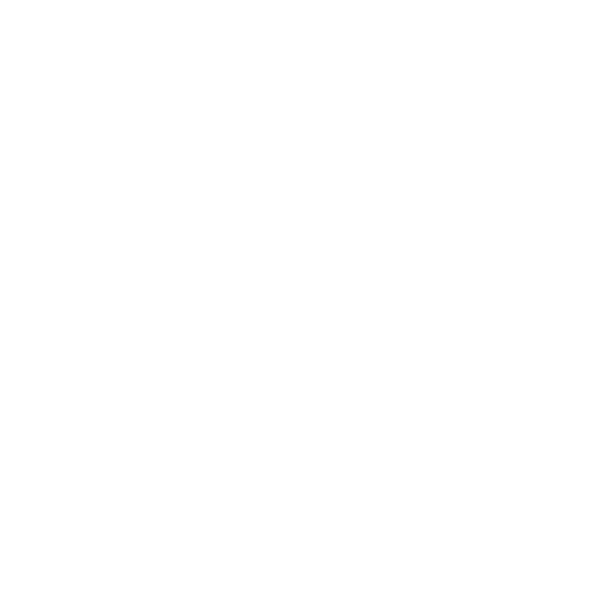

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x10d125110, at 0x11f24dfd0>

In [4]:
g = Graph()
graph_draw(g,inline=True)